# Assignment 2 | Classification using Convolutional Neural Networks

Student 1 + ID: Bashar Beshoti, 207370248

Student 2 + ID: Selan Abu Saleh, 212111439

### Introduction: 

CNNs have revolutionized the field of computer vision, their unique 
architecture, inspired by the visual cortex, allows CNNs to learn 
intricate patterns in images—detecting edges, textures, and even 
complex features at multiple levels.

 In this assignment we will explore the power of different CNN 
architectures and how to apply them for learning state of the art image 
classification algorithms.

 This assignment is divided into two parts. In the first part, you will 
implement a simple CNN in different ways and compare the 
performance on image classification.
 In the second part, we will use a more powerful network to achieve an 
almost perfect score on a real life dataset.

## Pre-Tasks : Import Libraries

We instantly imported main libraries that are going to be used in this section/project.

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchsummary import summary

import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from tqdm import tqdm

PyTorch check:

In [2]:
# Check if PyTorch is installed
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

# Check the device
device = torch.device("cuda" if cuda_available else "cpu")
print("Device:", device)

# If CUDA is available, print additional information
if cuda_available:
    print("CUDA version:", torch.version.cuda)
    print("Number of CUDA devices:", torch.cuda.device_count())
    print("CUDA device name:", torch.cuda.get_device_name(0))
    print("CUDA device capability:", torch.cuda.get_device_capability(0))

# Check if cuDNN is available
cudnn_available = torch.backends.cudnn.is_available()
print("cuDNN available:", cudnn_available)

# Check the version of cuDNN
if cudnn_available:
    print("cuDNN version:", torch.backends.cudnn.version())

# Check if MPS (Metal Performance Shaders) is available (for macOS)
mps_available = torch.backends.mps.is_available()
print("MPS available:", mps_available)

# Check if MPS is built (for macOS)
mps_built = torch.backends.mps.is_built()
print("MPS built:", mps_built)

PyTorch version: 2.5.1+cpu
CUDA available: False
Device: cpu
cuDNN available: False
MPS available: False
MPS built: False


## Section 1:  (CNNs on CIFAR-10)
__Introduction:__  Part 1: (CNNs on CIFAR-10) In this part of the assignment, you will design, implement, and experiment with Convolutional Neural Networks (CNNs) on the CIFAR-10 dataset.

The goal is to understand how different configurations (number of layers, kernel sizes, strides, and pooling techniques) impact model performance on image classification tasks.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 
classes, with 6,000 images per class. There are 50,000 training images 
and 10,000 test images.


### A: Load the dataset using torchvision-datasets library. Split the dataset into training, validation and test sets if not already provided like that, and showcase some samples from different classes from the training set.

The code loads and preprocesses the CIFAR-10 dataset, splits it into training, validation, and test sets, and visualizes some sample images via `show_samples` function.


100%|██████████| 170M/170M [00:50<00:00, 3.41MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Showing some samples from the CIFAR-10 training set:


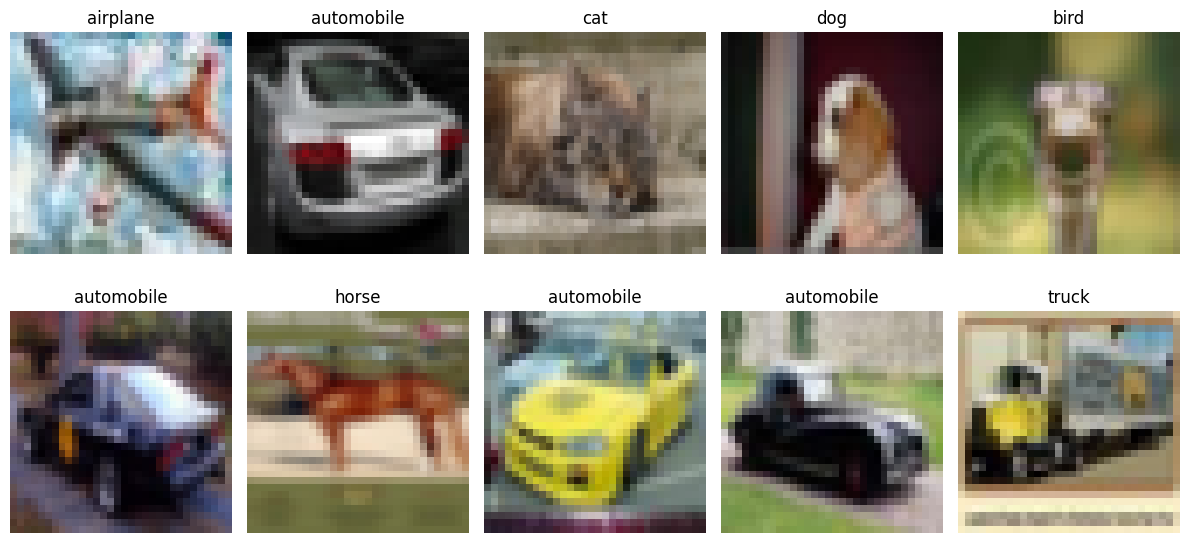

Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [3]:
# Define transformations (normalizing the data)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class labels in CIFAR-10
classes = (
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

# Function to visualize some images
def show_samples(dataset, classes, num_samples=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        # Get a random sample
        index = np.random.randint(0, len(dataset))
        img, label = dataset[index]
        img = img.permute(1, 2, 0)  # Change dimensions for visualization
        img = img * 0.5 + 0.5  # De-normalize the image

        # Plot the image
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Showcase samples from the training set
print("Showing some samples from the CIFAR-10 training set:")
show_samples(train_dataset, classes)
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

### B: The parameter search should be done on the validation set and then used to test the best model found on the test set.

The code below defines a simple Convolutional Neural Network (CNN) class with customizable layers, kernel size, stride, and pooling type. It includes a forward method for passing data through the network. This CNN structure and these layers to create a flexible and straightforward model for image classification. The combination of convolutional layers, activation functions (ReLU), and pooling layers helps in extracting and downsampling features from the input images, making the model effective for the assignment.

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, num_layers=2, kernel_size=3, stride=1, pool_type='max'):
        super(SimpleCNN, self).__init__()
        in_channels = 3  # RGB channels
        layers = []

        for i in range(num_layers):
            out_channels = 32 * (i + 1)
            layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size // 2),
                nn.ReLU(),
                nn.MaxPool2d(2) if pool_type == 'max' else nn.AvgPool2d(2)
            ])
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)
        self.fc = nn.Linear(in_channels * 8 * 8, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


The function `train_and_validate` trains, validates, and tests the model over a specified number of epochs. It stores metrics such as training loss, training accuracy, validation accuracy, and test accuracy for each epoch, which can be used for visualization and analysis of the model's performance. Then, `plot_metrics` function plots the training loss, training accuracy, validation accuracy, and test accuracy over the epochs. It helps visualize the model's performance and track its progress during training.

In [5]:
# Train, validate, and test the model, storing metrics for visualization
def train_and_validate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=5):
    model = model.to(device)

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)  # Use device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_acc = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Use device
                outputs = model(images)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        val_acc = correct_val / total_val
        val_accuracies.append(val_acc)

        # Test phase
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)  # Use device
                outputs = model(images)
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        test_acc = correct_test / total_test
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc:.3f}, "
              f"Val Acc: {val_acc:.3f}, Test Acc: {test_acc:.3f}")
    
    return train_losses, train_accuracies, val_accuracies, test_accuracies


In [6]:
# Function to plot the metrics
def plot_metrics(train_losses, train_accuracies, val_accuracies, test_accuracies, title=''):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss' + title, color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy' + title, color='green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy'+ title, color='orange')
    plt.plot(epochs, test_accuracies, label='Test Accuracy' + title, color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train, Validation, and Test Accuracy' + title)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and validate the model
train_losses, train_accuracies, val_accuracies, test_accuracies = train_and_validate(
    model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10
)

100%|██████████| 625/625 [00:10<00:00, 56.85it/s]


Epoch 1/10: Train Loss: 1.417, Train Acc: 0.497, Val Acc: 0.600, Test Acc: 0.601


100%|██████████| 625/625 [00:11<00:00, 55.55it/s]


Epoch 2/10: Train Loss: 1.051, Train Acc: 0.633, Val Acc: 0.657, Test Acc: 0.653


100%|██████████| 625/625 [00:11<00:00, 55.12it/s]


Epoch 3/10: Train Loss: 0.914, Train Acc: 0.680, Val Acc: 0.676, Test Acc: 0.672


100%|██████████| 625/625 [00:11<00:00, 55.28it/s]


Epoch 4/10: Train Loss: 0.821, Train Acc: 0.716, Val Acc: 0.685, Test Acc: 0.684


100%|██████████| 625/625 [00:11<00:00, 54.09it/s]


Epoch 5/10: Train Loss: 0.759, Train Acc: 0.739, Val Acc: 0.686, Test Acc: 0.686


100%|██████████| 625/625 [00:11<00:00, 53.25it/s]


Epoch 6/10: Train Loss: 0.698, Train Acc: 0.758, Val Acc: 0.702, Test Acc: 0.696


100%|██████████| 625/625 [00:11<00:00, 54.07it/s]


Epoch 7/10: Train Loss: 0.654, Train Acc: 0.774, Val Acc: 0.701, Test Acc: 0.694


100%|██████████| 625/625 [00:11<00:00, 53.97it/s]


Epoch 8/10: Train Loss: 0.610, Train Acc: 0.790, Val Acc: 0.702, Test Acc: 0.702


100%|██████████| 625/625 [00:11<00:00, 53.21it/s]


Epoch 9/10: Train Loss: 0.571, Train Acc: 0.802, Val Acc: 0.700, Test Acc: 0.694


100%|██████████| 625/625 [00:11<00:00, 52.94it/s]


Epoch 10/10: Train Loss: 0.536, Train Acc: 0.815, Val Acc: 0.701, Test Acc: 0.690


#### After the training, choose a random image from the test set, push it 
through the model and print the convolution filters of the first layer after 
the training to see the feature maps and visualize what the model 
learned on it.

Visualizing the first convolutional layer filters:


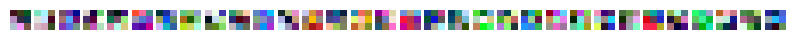

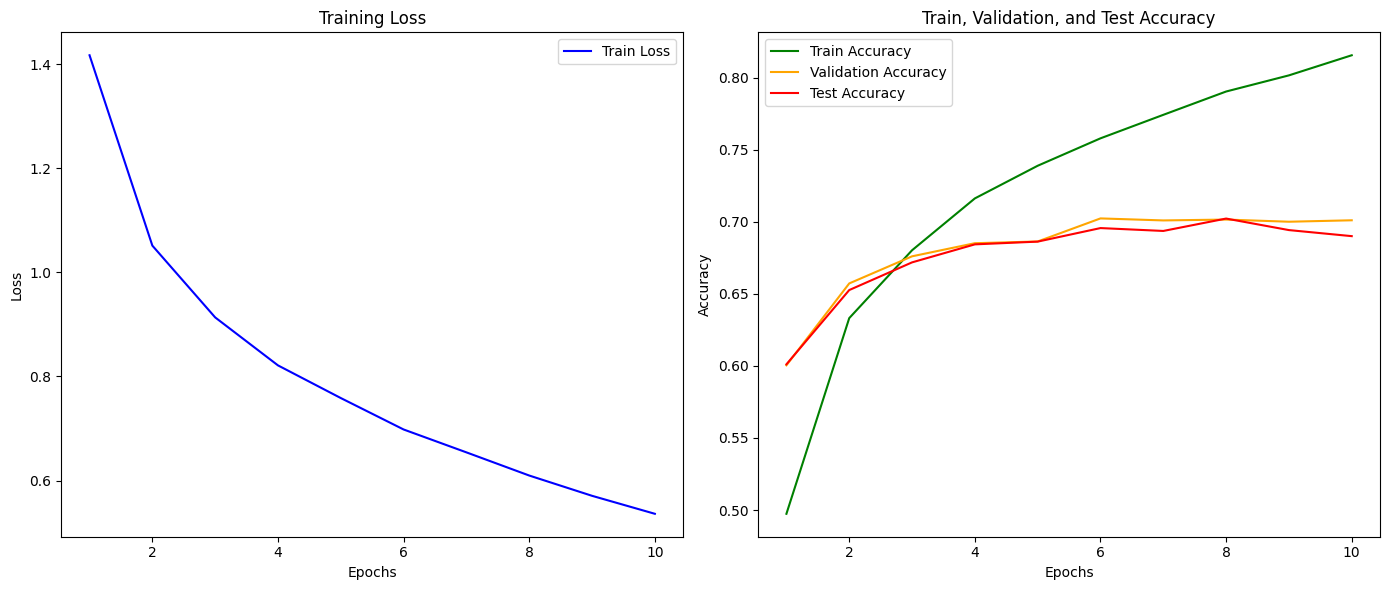

In [8]:
import random

# Choose a random image from the test set
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Push the image through the model
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
model.eval()
with torch.no_grad():
    output = model(image)

# Get the first convolutional layer filters
first_conv_layer = model.conv[0]
filters = first_conv_layer.weight.data
num_filters = filters.size(0)

# Visualize the filters
def visualize_filters(filters, num_filters=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_filters):
        plt.subplot(1, num_filters, i + 1)
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())  # Normalize to [0, 1]
        plt.imshow(filter_img)
        plt.axis('off')
    plt.show()

print("Visualizing the first convolutional layer filters:")
visualize_filters(filters,num_filters)

# Plot training and validation metrics
plot_metrics(train_losses, train_accuracies, val_accuracies, test_accuracies)

### C: You are given 4 subtasks where you will implement or add stuff on previous tasks, then compare the results and explain them.

    Subtask 1:
    Create a simple CNN with 2 convolutional layers and 1 fully connected layer with a softmax output such that:
    - Conv Layer 1 contains 16 filters of 3x3 kernels, stride 1, padding 1.
    - Conv Layer 2 contains 32 filters of 3x3 kernels, stride 1, padding 1.
    - Max Pooling  after each Conv layer
    - Flattening followed by a fully connected layer
    - Use Relu as an activation function on the convolutional layers, Adam or 
    - SGD as an optimizer and Cross Entropy as a loss function.
    Train the network on 10 epochs and test it.

100%|██████████| 625/625 [00:07<00:00, 85.62it/s]


Epoch 1/10: Train Loss: 1.495, Train Acc: 0.466, Val Acc: 0.546, Test Acc: 0.557


100%|██████████| 625/625 [00:07<00:00, 87.38it/s]


Epoch 2/10: Train Loss: 1.174, Train Acc: 0.589, Val Acc: 0.619, Test Acc: 0.615


100%|██████████| 625/625 [00:07<00:00, 88.58it/s]


Epoch 3/10: Train Loss: 1.042, Train Acc: 0.638, Val Acc: 0.629, Test Acc: 0.631


100%|██████████| 625/625 [00:07<00:00, 88.39it/s]


Epoch 4/10: Train Loss: 0.965, Train Acc: 0.665, Val Acc: 0.657, Test Acc: 0.652


100%|██████████| 625/625 [00:07<00:00, 86.66it/s]


Epoch 5/10: Train Loss: 0.905, Train Acc: 0.686, Val Acc: 0.672, Test Acc: 0.669


100%|██████████| 625/625 [00:07<00:00, 87.36it/s]


Epoch 6/10: Train Loss: 0.859, Train Acc: 0.702, Val Acc: 0.673, Test Acc: 0.674


100%|██████████| 625/625 [00:07<00:00, 86.03it/s]


Epoch 7/10: Train Loss: 0.823, Train Acc: 0.717, Val Acc: 0.670, Test Acc: 0.671


100%|██████████| 625/625 [00:07<00:00, 84.17it/s]


Epoch 8/10: Train Loss: 0.792, Train Acc: 0.726, Val Acc: 0.678, Test Acc: 0.679


100%|██████████| 625/625 [00:07<00:00, 87.85it/s]


Epoch 9/10: Train Loss: 0.770, Train Acc: 0.735, Val Acc: 0.682, Test Acc: 0.683


100%|██████████| 625/625 [00:07<00:00, 85.84it/s]


Epoch 10/10: Train Loss: 0.743, Train Acc: 0.742, Val Acc: 0.676, Test Acc: 0.679


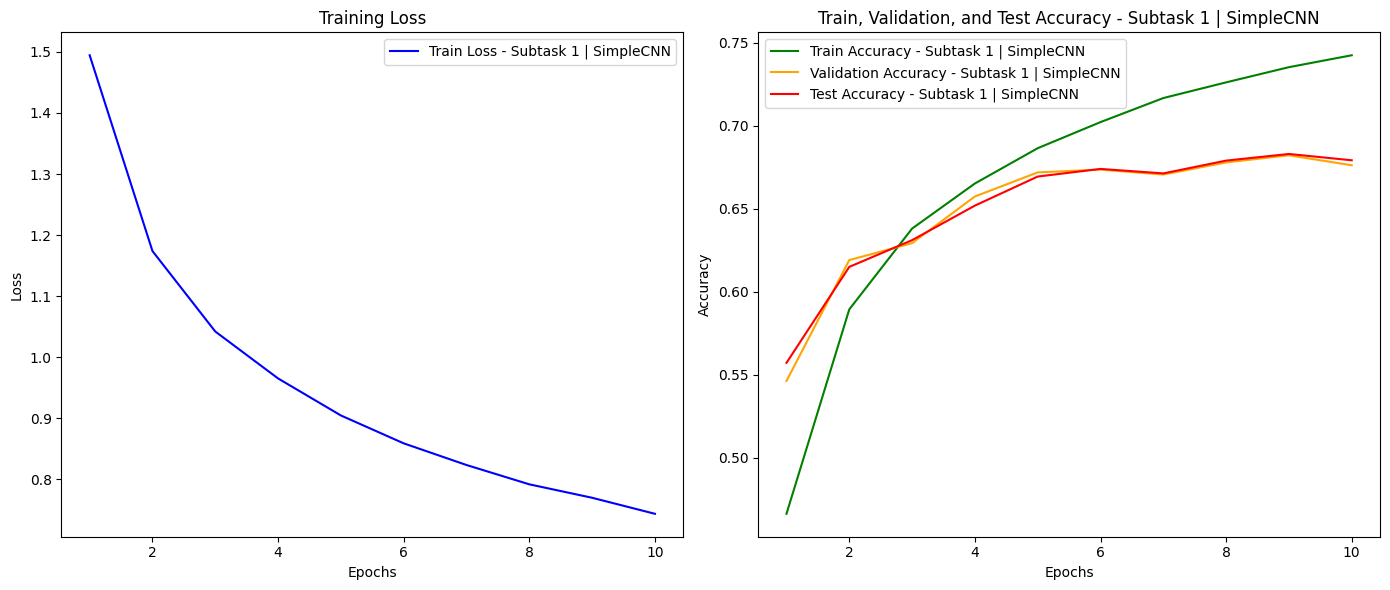

In [9]:
class SimpleCNN_subtask_1(nn.Module):
    def __init__(self):
        super(SimpleCNN_subtask_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 8 * 8, 10)  # Assuming input images are 32x32 and output classes are 10
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
        # return self.softmax(x)

# Model, loss function, and optimizer
model_subtask_1 = SimpleCNN_subtask_1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_subtask_1.parameters(), lr=0.001)

# Train the model and test it
train_losses_subtask1, train_accuracies_subtask1, val_accuracies_subtask1, test_accuracies_subtask1 = train_and_validate(
    model_subtask_1, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10
)

# Plot training and validation metrics
plot_metrics(train_losses_subtask1, train_accuracies_subtask1, val_accuracies_subtask1, test_accuracies_subtask1," - Subtask 1 | SimpleCNN")

    Subtask 2:
 
    - Increase the depth of the network by adding 2 additional layers.
    - The first additional one with 64 filters and the second additional one with 128 with the same kernel sizes as before.
    - Train and test the network and compare it with the previous ones.

100%|██████████| 625/625 [00:10<00:00, 57.15it/s]


Epoch 1/10: Train Loss: 1.589, Train Acc: 0.418, Val Acc: 0.516, Test Acc: 0.527


100%|██████████| 625/625 [00:11<00:00, 55.52it/s]


Epoch 2/10: Train Loss: 1.198, Train Acc: 0.572, Val Acc: 0.607, Test Acc: 0.612


100%|██████████| 625/625 [00:11<00:00, 54.98it/s]


Epoch 3/10: Train Loss: 1.016, Train Acc: 0.640, Val Acc: 0.625, Test Acc: 0.629


100%|██████████| 625/625 [00:11<00:00, 54.14it/s]


Epoch 4/10: Train Loss: 0.887, Train Acc: 0.687, Val Acc: 0.654, Test Acc: 0.659


100%|██████████| 625/625 [00:11<00:00, 53.89it/s]


Epoch 5/10: Train Loss: 0.793, Train Acc: 0.723, Val Acc: 0.683, Test Acc: 0.693


100%|██████████| 625/625 [00:17<00:00, 36.29it/s]


Epoch 6/10: Train Loss: 0.708, Train Acc: 0.750, Val Acc: 0.691, Test Acc: 0.698


100%|██████████| 625/625 [00:25<00:00, 24.86it/s]


Epoch 7/10: Train Loss: 0.634, Train Acc: 0.779, Val Acc: 0.707, Test Acc: 0.718


100%|██████████| 625/625 [00:24<00:00, 25.14it/s]


Epoch 8/10: Train Loss: 0.571, Train Acc: 0.800, Val Acc: 0.709, Test Acc: 0.718


100%|██████████| 625/625 [00:25<00:00, 24.76it/s]


Epoch 9/10: Train Loss: 0.510, Train Acc: 0.820, Val Acc: 0.700, Test Acc: 0.709


100%|██████████| 625/625 [00:24<00:00, 25.01it/s]


Epoch 10/10: Train Loss: 0.454, Train Acc: 0.842, Val Acc: 0.709, Test Acc: 0.717


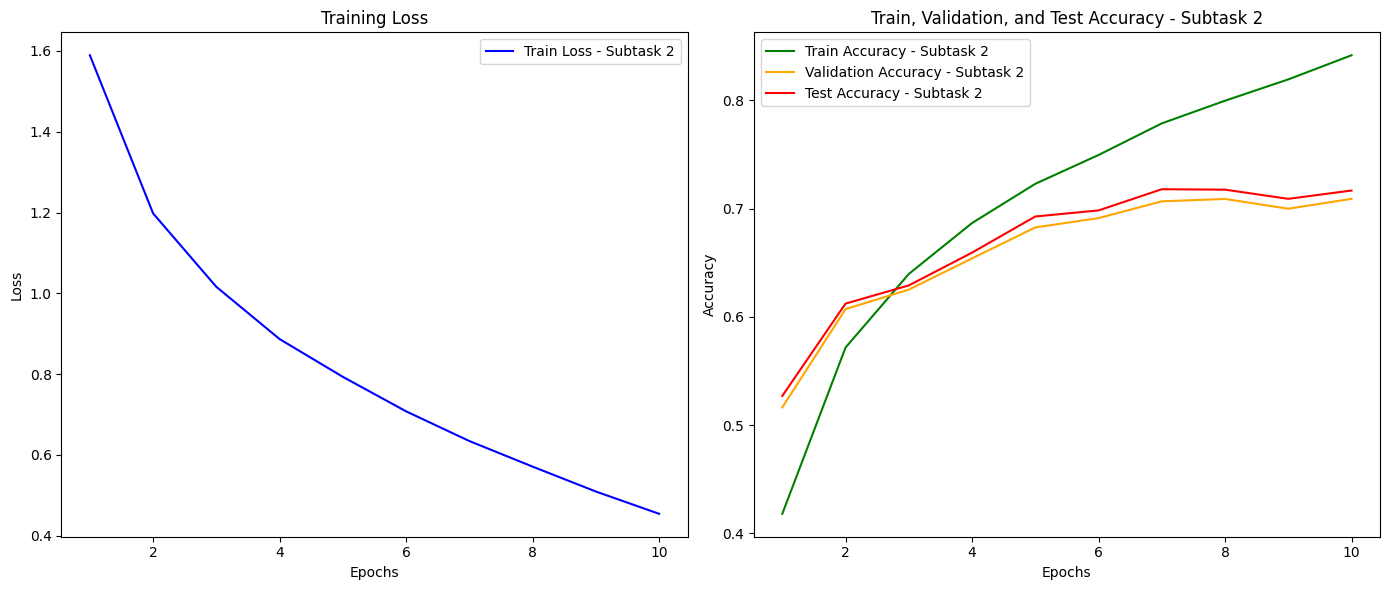

In [10]:
class SimpleCNN_subtask_2(nn.Module):
    def __init__(self):
        super(SimpleCNN_subtask_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # New Layer 1
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # New Layer 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(128 * 2 * 2, 10)  # Updated to match the new feature map size
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))  # New Layer 1
        x = self.pool(x)
        x = self.relu(self.conv4(x))  # New Layer 2
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Instantiate the new model
model_subtask_2 = SimpleCNN_subtask_2().to(device)

# Use the same loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_subtask_2.parameters(), lr=0.001)

# Train the model and test it
train_losses_subtask2, train_accuracies_subtask2, val_accuracies_subtask2, test_accuracies_subtask2 = train_and_validate(
    model_subtask_2, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10
)

# Plot training and validation metrics
plot_metrics(train_losses_subtask2, train_accuracies_subtask2, val_accuracies_subtask2, test_accuracies_subtask2," - Subtask 2")


    Subtask 3:

    - Remove the 2 new layers.
    - Increase the kernel sizes to 5x5 and the stride to 2.
    - Train and test the network and compare it with the previous.

100%|██████████| 625/625 [00:15<00:00, 39.99it/s]


Epoch 1/10: Train Loss: 1.604, Train Acc: 0.422, Val Acc: 0.509, Test Acc: 0.513


100%|██████████| 625/625 [00:08<00:00, 71.54it/s] 


Epoch 2/10: Train Loss: 1.293, Train Acc: 0.544, Val Acc: 0.551, Test Acc: 0.558


100%|██████████| 625/625 [00:05<00:00, 107.05it/s]


Epoch 3/10: Train Loss: 1.188, Train Acc: 0.582, Val Acc: 0.581, Test Acc: 0.586


100%|██████████| 625/625 [00:05<00:00, 107.34it/s]


Epoch 4/10: Train Loss: 1.122, Train Acc: 0.606, Val Acc: 0.604, Test Acc: 0.600


100%|██████████| 625/625 [00:05<00:00, 108.07it/s]


Epoch 5/10: Train Loss: 1.070, Train Acc: 0.627, Val Acc: 0.602, Test Acc: 0.604


100%|██████████| 625/625 [00:05<00:00, 108.67it/s]


Epoch 6/10: Train Loss: 1.034, Train Acc: 0.639, Val Acc: 0.608, Test Acc: 0.615


100%|██████████| 625/625 [00:05<00:00, 107.38it/s]


Epoch 7/10: Train Loss: 0.998, Train Acc: 0.653, Val Acc: 0.612, Test Acc: 0.615


100%|██████████| 625/625 [00:05<00:00, 108.25it/s]


Epoch 8/10: Train Loss: 0.970, Train Acc: 0.661, Val Acc: 0.620, Test Acc: 0.623


100%|██████████| 625/625 [00:05<00:00, 107.73it/s]


Epoch 9/10: Train Loss: 0.944, Train Acc: 0.671, Val Acc: 0.622, Test Acc: 0.628


100%|██████████| 625/625 [00:05<00:00, 108.61it/s]


Epoch 10/10: Train Loss: 0.926, Train Acc: 0.680, Val Acc: 0.614, Test Acc: 0.618


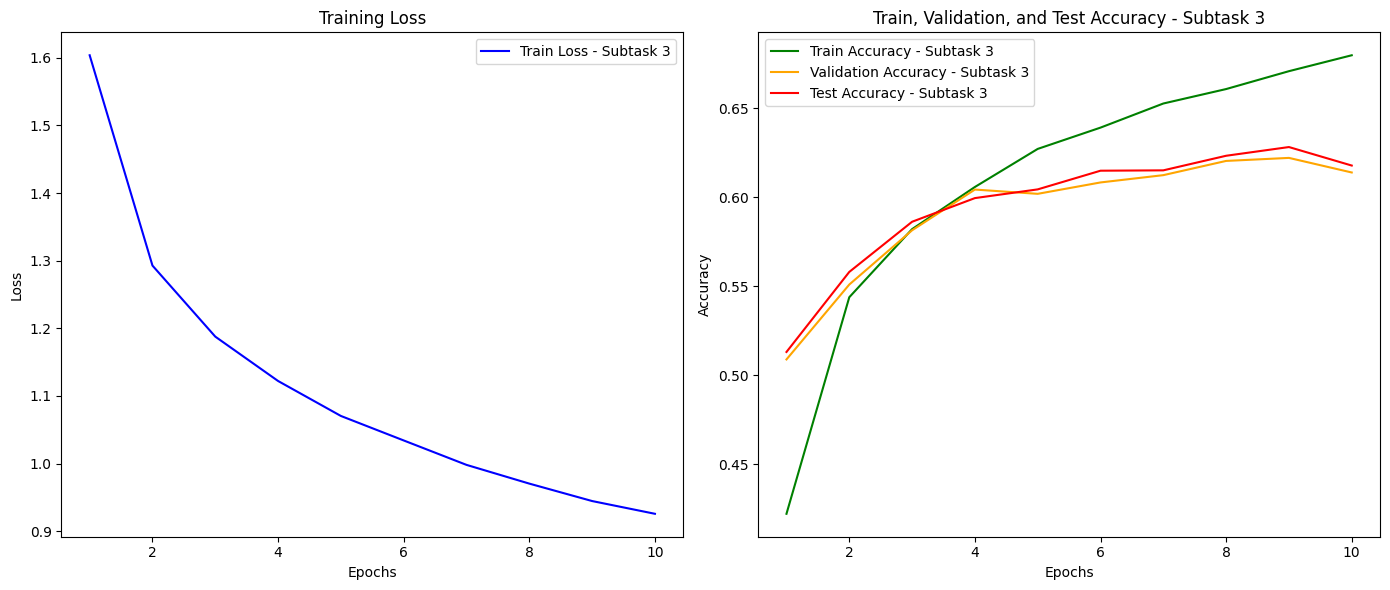

In [11]:
class SimpleCNN_subtask3(nn.Module):
    def __init__(self):
        super(SimpleCNN_subtask3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding=2)  # Kernel size 5x5, stride 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2)  # Kernel size 5x5, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 4 * 4, 10)  # Adjusted input size
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
# Instantiate the new model
model_subtask3 = SimpleCNN_subtask3().to(device)
# Use the same loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_subtask3.parameters(), lr=0.001)

# Train the new model and evaluate it
train_losses_subtask3, train_accuracies_subtask3, val_accuracies_subtask3, test_accuracies_subtask3 = train_and_validate(
    model_subtask3, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10
)

# Plot training and validation metrics
plot_metrics(train_losses_subtask3, train_accuracies_subtask3, val_accuracies_subtask3, test_accuracies_subtask3," - Subtask 3")

    Subtask 4:
    - Change Max pooling to average pooling on the best network so far and observe the changes.
    - Train and test the network and compare it with the previous best.

100%|██████████| 625/625 [00:10<00:00, 59.57it/s]


Epoch 1/10: Train Loss: 1.706, Train Acc: 0.370, Val Acc: 0.450, Test Acc: 0.458


100%|██████████| 625/625 [00:11<00:00, 56.69it/s]


Epoch 2/10: Train Loss: 1.405, Train Acc: 0.491, Val Acc: 0.508, Test Acc: 0.518


100%|██████████| 625/625 [00:11<00:00, 56.27it/s]


Epoch 3/10: Train Loss: 1.275, Train Acc: 0.543, Val Acc: 0.562, Test Acc: 0.560


100%|██████████| 625/625 [00:11<00:00, 55.10it/s]


Epoch 4/10: Train Loss: 1.178, Train Acc: 0.580, Val Acc: 0.593, Test Acc: 0.597


100%|██████████| 625/625 [00:11<00:00, 54.75it/s]


Epoch 5/10: Train Loss: 1.094, Train Acc: 0.609, Val Acc: 0.600, Test Acc: 0.609


100%|██████████| 625/625 [00:11<00:00, 54.55it/s]


Epoch 6/10: Train Loss: 1.026, Train Acc: 0.635, Val Acc: 0.609, Test Acc: 0.617


100%|██████████| 625/625 [00:11<00:00, 54.75it/s]


Epoch 7/10: Train Loss: 0.973, Train Acc: 0.658, Val Acc: 0.643, Test Acc: 0.647


100%|██████████| 625/625 [00:11<00:00, 54.48it/s]


Epoch 8/10: Train Loss: 0.922, Train Acc: 0.676, Val Acc: 0.643, Test Acc: 0.644


100%|██████████| 625/625 [00:11<00:00, 54.97it/s]


Epoch 9/10: Train Loss: 0.873, Train Acc: 0.692, Val Acc: 0.656, Test Acc: 0.663


100%|██████████| 625/625 [00:11<00:00, 55.25it/s]


Epoch 10/10: Train Loss: 0.836, Train Acc: 0.705, Val Acc: 0.668, Test Acc: 0.674


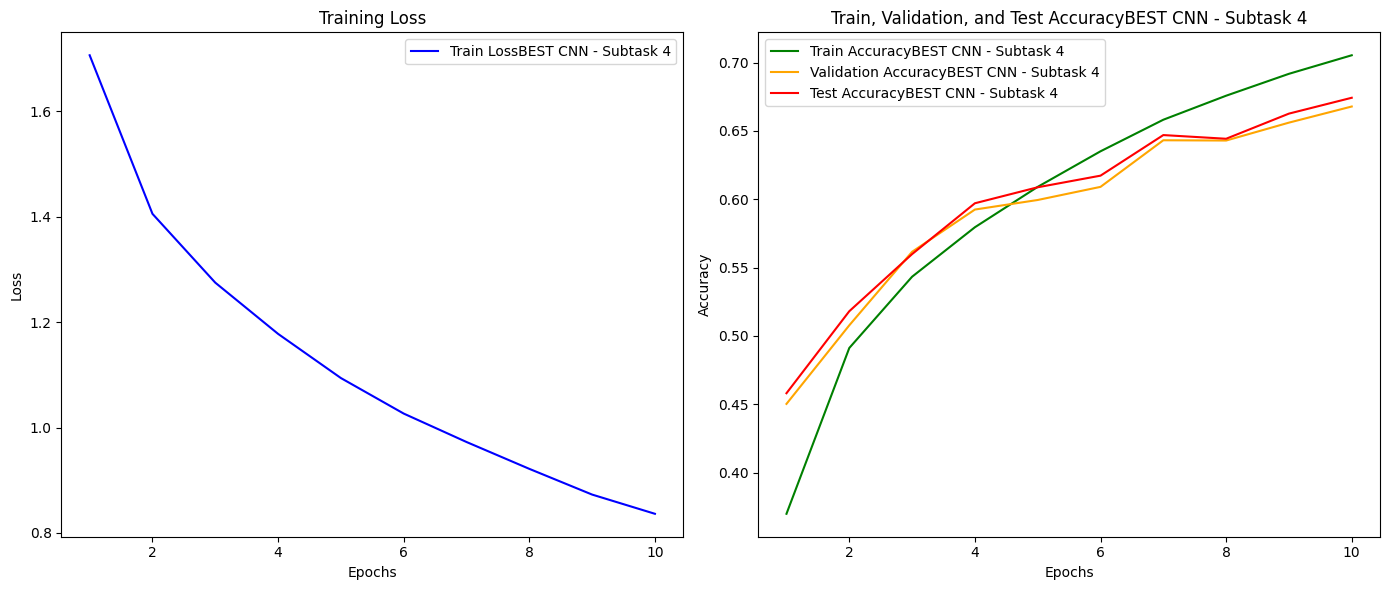

In [12]:
class SimpleCNN_subtask4(nn.Module):
    def __init__(self):
        super(SimpleCNN_subtask4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Changed MaxPool2d to AvgPool2d
        self.fc = nn.Linear(128 * 2 * 2, 10)  # Adjusted for the deeper network from Subtask 2
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Instantiate the new model
model_subtask4 = SimpleCNN_subtask4().to(device)

# Use the same loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_subtask4.parameters(), lr=0.001)

# Train the new model and evaluate it
train_losses_subtask4, train_accuracies_subtask4, val_accuracies_subtask4, test_accuracies_subtask4 = train_and_validate(
    model_subtask4, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10
)

# Plot training and validation metrics
plot_metrics(train_losses_subtask4, train_accuracies_subtask4, val_accuracies_subtask4, test_accuracies_subtask4,"BEST CNN - Subtask 4")


### Summary

In [13]:
# Print summary of parameters and variables
print(f"Batch size: {batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Number of epochs: 10")
print(f"Loss function: Cross Entropy Loss")
print(f"Optimizer: Adam")
print(f"Device: {device}")

# Function to count the number of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to print model summary
def print_model_summary(model):
    summary(model, (3, 32, 32))

# Plot comparison between subtasks
def plot_comparison(train_losses_list, train_accuracies_list, val_accuracies_list, test_accuracies_list, titles):
    epochs = range(1, len(train_losses_list[0]) + 1)

    plt.figure(figsize=(20, 10))

    # Plot training loss
    plt.subplot(2, 2, 1)
    for i, train_losses in enumerate(train_losses_list):
        plt.plot(epochs, train_losses, label=titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()

    # Plot training accuracy
    plt.subplot(2, 2, 2)
    for i, train_accuracies in enumerate(train_accuracies_list):
        plt.plot(epochs, train_accuracies, label=titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Comparison')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(2, 2, 3)
    for i, val_accuracies in enumerate(val_accuracies_list):
        plt.plot(epochs, val_accuracies, label=titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.legend()

    # Plot test accuracy
    plt.subplot(2, 2, 4)
    for i, test_accuracies in enumerate(test_accuracies_list):
        plt.plot(epochs, test_accuracies, label=titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()


Batch size: 64
Learning rate: 0.001
Number of epochs: 10
Loss function: Cross Entropy Loss
Optimizer: Adam
Device: cpu


In [14]:
print(f"Simple CNN Summary: \n")
print_model_summary(model)

Simple CNN Summary: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                   [-1, 10]          40,970
Total params: 60,362
Trainable params: 60,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.84
Params size (MB): 0.23
Estimated Total Size (MB): 1.09
----------------------------------------------------------------


In [15]:
print(f"\nSimpleCNN_subtask_1 Summary: \n")
print_model_summary(model_subtask_1)


SimpleCNN_subtask_1 Summary: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Linear-7                   [-1, 10]          20,490
Total params: 25,578
Trainable params: 25,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.42
Params size (MB): 0.10
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


In [16]:
print(f"\nSimpleCNN_subtask_2 Summary: \n")
print_model_summary(model_subtask_2)


SimpleCNN_subtask_2 Summary: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]          73,856
             ReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                   [-1, 10]           5,130
Total p

In [17]:
print(f"\nSimpleCNN_subtask3 Summary: \n")
print_model_summary(model_subtask3)


SimpleCNN_subtask3 Summary: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]           1,216
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]          12,832
              ReLU-4             [-1, 32, 8, 8]               0
         MaxPool2d-5             [-1, 32, 4, 4]               0
            Linear-6                   [-1, 10]           5,130
Total params: 19,178
Trainable params: 19,178
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.07
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


In [18]:
print(f"\nSimpleCNN_subtask4 Summary: \n")
print_model_summary(model_subtask4)


SimpleCNN_subtask4 Summary: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         AvgPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         AvgPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
         AvgPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]          73,856
             ReLU-11            [-1, 128, 4, 4]               0
        AvgPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                   [-1, 10]           5,130
Total pa

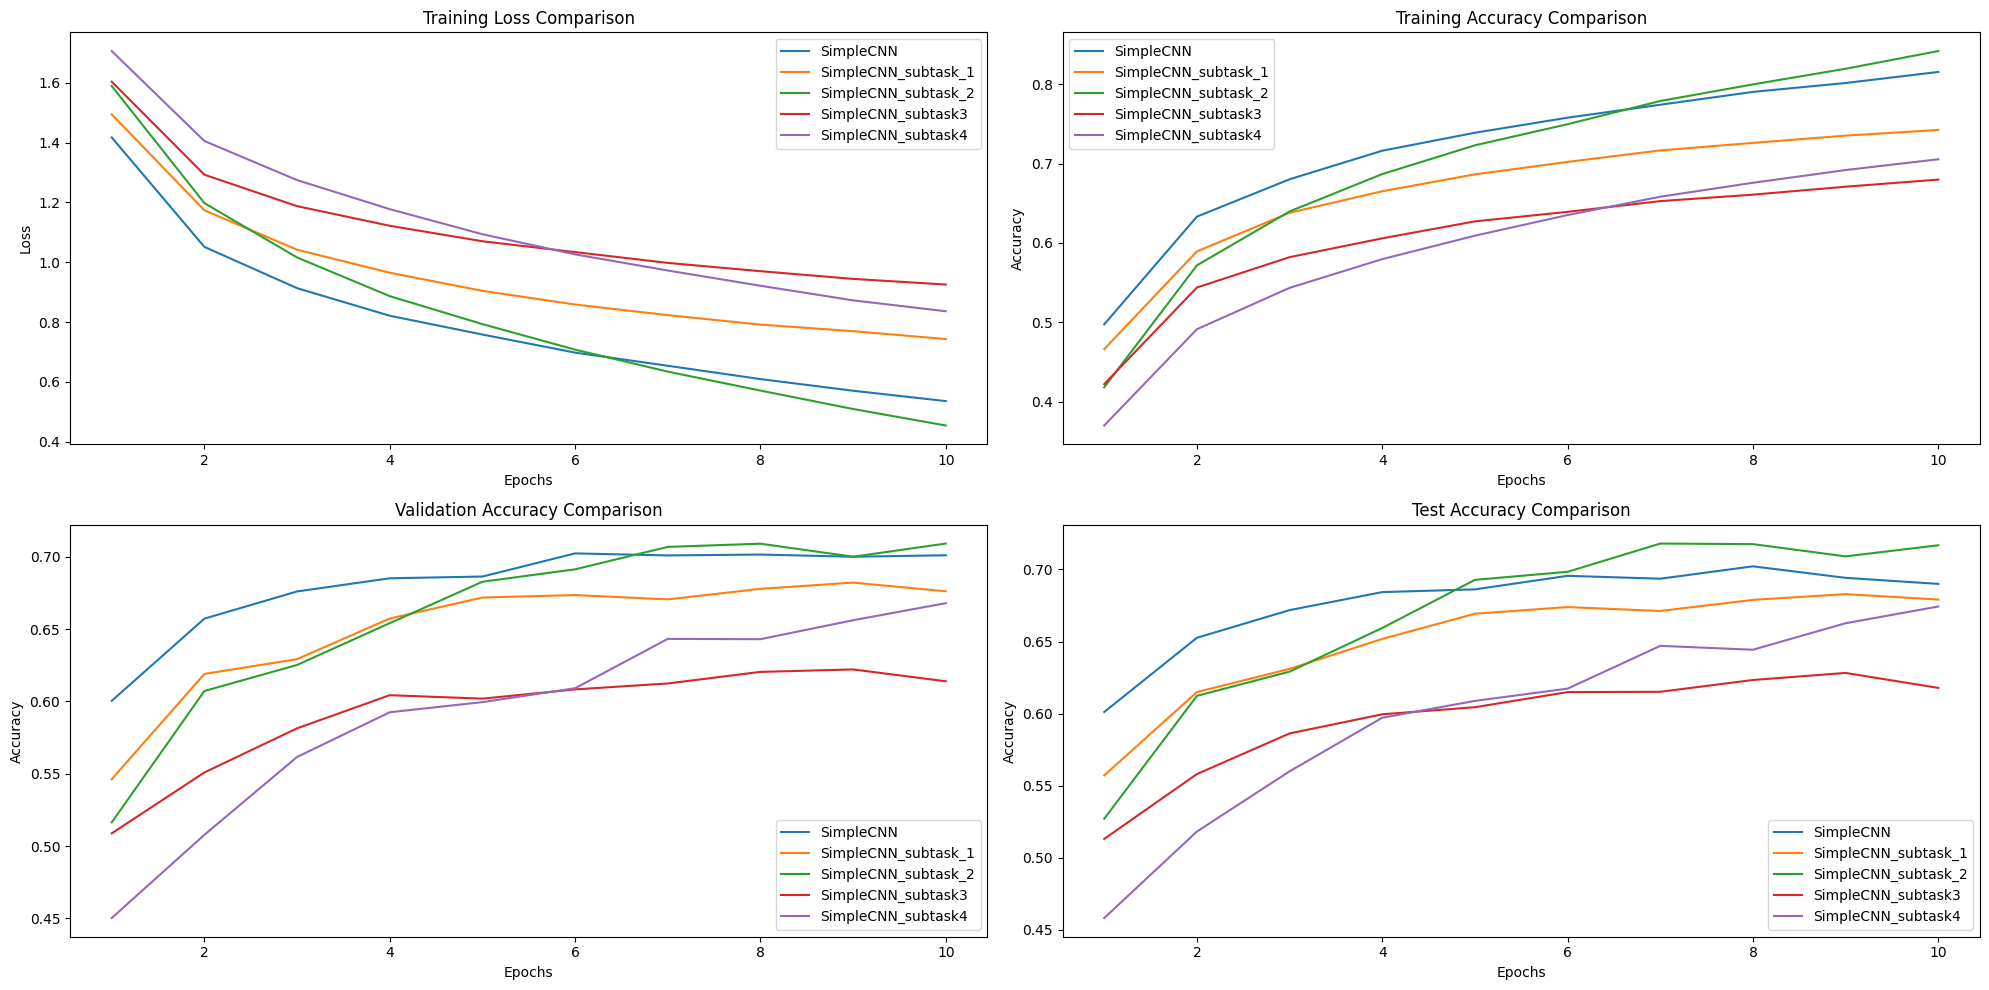

In [19]:
# Titles for the subtasks
titles = [
    "SimpleCNN",
    "SimpleCNN_subtask_1",
    "SimpleCNN_subtask_2",
    "SimpleCNN_subtask3",
    "SimpleCNN_subtask4"
]

# Plot the comparison
plot_comparison(
    [train_losses, train_losses_subtask1, train_losses_subtask2, train_losses_subtask3, train_losses_subtask4],
    [train_accuracies, train_accuracies_subtask1, train_accuracies_subtask2, train_accuracies_subtask3, train_accuracies_subtask4],
    [val_accuracies, val_accuracies_subtask1, val_accuracies_subtask2, val_accuracies_subtask3, val_accuracies_subtask4],
    [test_accuracies, test_accuracies_subtask1, test_accuracies_subtask2, test_accuracies_subtask3, test_accuracies_subtask4],
    titles
)

## Submission:
For this assignment, make sure your submission is clear and well organized. You should include a notebook for each part of the assignment with all code cells run and explained.  There’s no need to put the files in a zip file, just submit your 2 `ipynb` files with their names being `HW1_ID1_ID2.ipynb` OR `HW1_ID2_ID1.ipynb`.

- Add text cells to introduce each section, explaining what you did and why. Keep your notebooks tidy and easy to follow, with the names of all group members at the top.

- In each notebook, include comments in your code and use text to describe what you’re doing in each section. Visualize your results with plots that help explain the data and model performance.

- Finally, print each model you use, showing the layer details and the total number of parameters.

- Only the pytorch library can be used as a deep learning tool to work with the models, you can’t use keras or tensorflow under any 
circumstances, you may use other libraries for manipulating the dataset and preprocessing as long as it doesn’t affect the model definition within pytorch.